In [2]:
import os
import random

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD,Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm.notebook import tqdm


%matplotlib inline

In [3]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
INPUT_DIR = '/home/n2b/BootCamp23/kaggle/bootcamp-kaggle/data'

PATH = {
    'train': os.path.join(INPUT_DIR, 'train.csv'),
    'sample_submission': os.path.join(INPUT_DIR, 'sample_submission.csv'),
    'train_image_dir': os.path.join(INPUT_DIR, 'train_images/train_images'),
    'test_image_dir': os.path.join(INPUT_DIR, 'test_images/test_images'),
}

ID = 'fname'
TARGET = 'label'

SEED = 42
seed_everything(SEED)

# GPU settings for PyTorch (explained later...)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Parameters for neural network. We will see the details later...
PARAMS = {
    'valid_size': 0.2,
    'batch_size': 256,
    'epochs': 30,
    'lr': 0.01,
    'valid_batch_size': 256,
    'test_batch_size': 256,
}

In [5]:
train_df = pd.read_csv(PATH['train'])
sample_submission_df = pd.read_csv(PATH['sample_submission'])

In [6]:
print(f'number of train data: {len(train_df)}')
print(f'number of test data: {len(sample_submission_df)}')

number of train data: 60000
number of test data: 10000


In [7]:
print(f'number of unique label: {train_df[TARGET].nunique()}')

number of unique label: 10


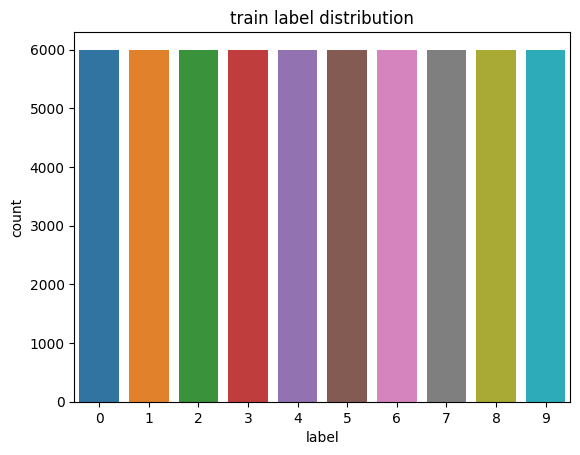

In [8]:
sns.countplot(x = train_df[TARGET])
plt.title('train label distribution')
plt.show()

In [9]:
train_df.head()

,fname,label
0,train_0.png,8
1,train_1.png,7
2,train_2.png,0
3,train_3.png,1
4,train_4.png,4


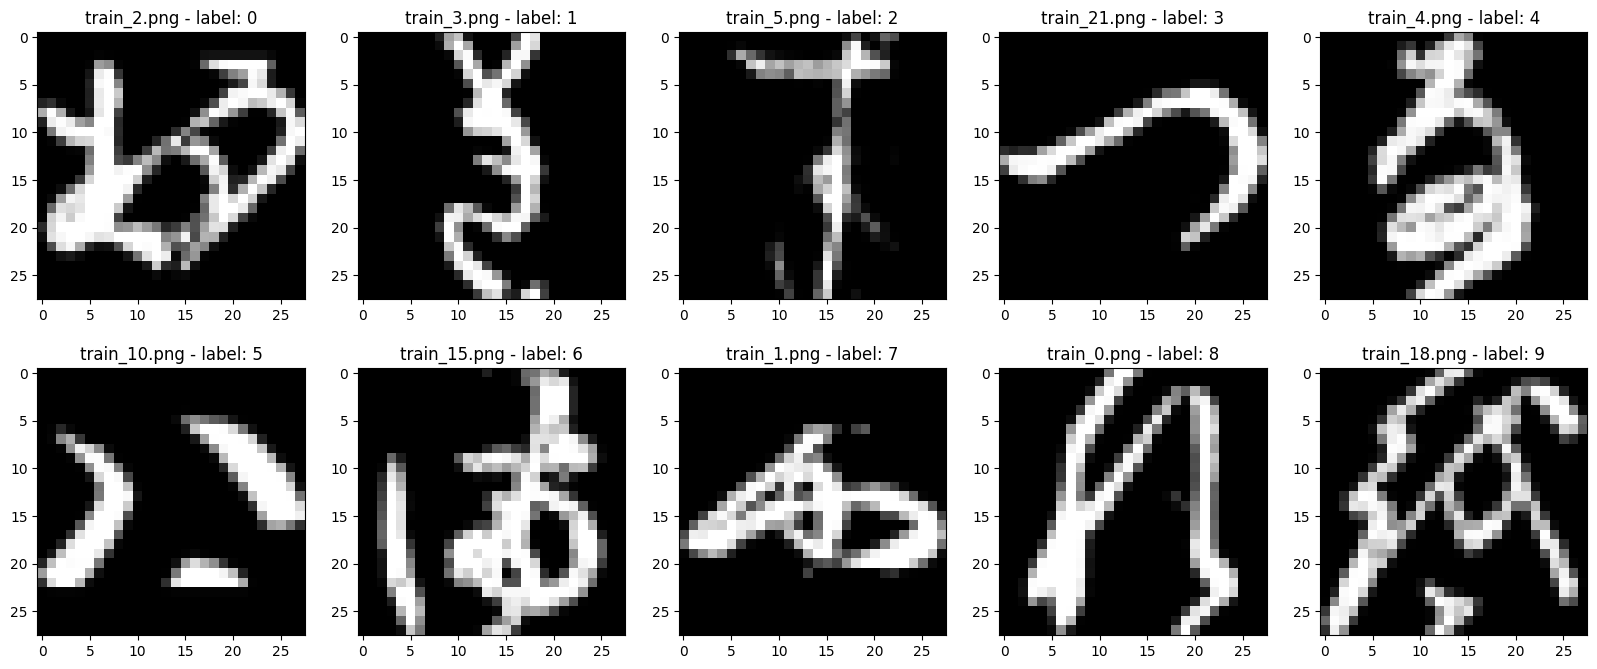

In [10]:
sample = train_df.groupby(TARGET).first().reset_index()

fig, ax = plt.subplots(2, 5)
fig.set_size_inches(4 * 5, 4 * 2)

for i, row in sample.iterrows():
    fname, label = row[ID], row[TARGET]
    img = cv2.imread(os.path.join(PATH['train_image_dir'], fname))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ax[i//5,i%5].imshow(img, 'gray')
    ax[i//5,i%5].set_title(f'{fname} - label: {label}')

In [11]:
print(f'shape of image: {img.shape}')

shape of image: (28, 28)


In [12]:
class KMNISTDataset(Dataset):
    def __init__(self, fname_list, label_list, image_dir, transform=None):
        super().__init__()
        self.fname_list = fname_list
        self.label_list = label_list
        self.image_dir = image_dir
        self.transform = transform
        
    # Datasetを実装するときにはtorch.utils.data.Datasetを継承する
    # __len__と__getitem__を実装する
    
    def __len__(self):
        return len(self.fname_list)
    
    def __getitem__(self, idx):
        fname = self.fname_list[idx]
        label = self.label_list[idx]
        
        image = cv2.imread(os.path.join(self.image_dir, fname))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        if self.transform is not None:
            image = self.transform(image)
        # __getitem__でデータを返す前にtransformでデータに前処理をしてから返すことがポイント
        return image, label

In [13]:
# 以下を埋めてみよう
# 今回の研修では
# モデルとして入力から出力チャネル数6, kernel_size5の畳み込み層→Maxpooling(2×2)→出力チャネル数12, kernel_size3の畳み込み層
# → MaxPooling(2×2)→1次元にする→Linearで10次元出力
# というモデルを作成してください(strideなどは考えないでください)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 出力チャンネル数6, kernel size 5のCNNを定義する
        # 畳み込みの定義はPytorchの場合torch.nn.Conv2dで行います。ヒント:白黒画像とはチャネル数いくつかは自分で考えよう
        # 公式documentで使い方を確認する力をつけてほしいので、自分でconv2dなどの使い方は調べよう
        self.conv1 = nn.Conv2d(1, 64, 3, padding = "same")
        self.conv2 = nn.Conv2d(64, 64, 3, padding = "same")
        
        
        # Maxpoolingの定義(fowardでするのでもどっちでも)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
       
        # Dropoutの定義
        self.dropout1 = nn.Dropout(0.7)
        self.dropout2 = nn.Dropout2d(0.5)
        # Linearの定義

        # Flattenの定義
        self.flatten = nn.Flatten()
        # 線形変換を行う層を定義してあげます: y = Wx + b
        # self.conv1, conv2のあと，maxpoolingを通すことで，
        # self.fc1に入力されるTensorの次元は何になっているか計算してみよう！
        # これを10クラス分類なので，10次元に変換するようなLinear層を定義します
        
        self.softmax = nn.Softmax()

        self.fc1 = nn.Linear(7*7*64, 128)
        self.fc2 = nn.Linear(128, 10)

        # バッチ正規化の定義
        self.bn1 = nn.BatchNorm2d(64)

    
    def forward(self, x):
        batch_size = x.shape[0]
        # forward関数の中では，，入力 x を順番にレイヤーに通していきます．みていきましょう．    
        # まずは，画像をCNNに通します
        x = self.conv1(x)
        x = F.leaky_relu(x)
        x = self.conv2(x)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = F.leaky_relu(x)
        x = self.maxpool1(x)
        x = self.flatten(x)
       



        # 少しトリッキーなことが起きます．
        # CNNの出力結果を fully-connected layer に入力するために
        # 1次元のベクトルにしてやる必要があります
        # 正確には，　(batch_size, channel, height, width) --> (batch_size, channel * height * width)
        x = x.view(batch_size, -1)
        
        # linearと活性化関数に通します
        x = F.leaky_relu(x)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        
        return x

In [14]:
net = Net()

In [15]:
train_df, valid_df = train_test_split(
    train_df, test_size=PARAMS['valid_size'], random_state=SEED, shuffle=True
)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # numpy.arrayで読み込まれた画像をPyTorch用のTensorに変換します．
    transforms.Normalize((0.5, ), (0.5, ))
    #正規化の処理も加えます。
])

train_dataset = KMNISTDataset(train_df[ID], train_df[TARGET], PATH['train_image_dir'], transform=transform)
valid_dataset = KMNISTDataset(valid_df[ID], valid_df[TARGET], PATH['train_image_dir'], transform=transform)

# DataLoaderを用いてバッチサイズ分のデータを生成します。shuffleをtrueにすることでデータをshuffleしてくれます
train_dataloader = DataLoader(train_dataset, batch_size=PARAMS['batch_size'], shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=PARAMS['valid_batch_size'], shuffle=False)

In [17]:
#model = MLP().to(DEVICE)
model = Net().to(DEVICE)

In [18]:
model = model.to("cuda")
#tensor = tensor.to("cuda")

In [19]:
optim = SGD(model.parameters(), lr=PARAMS['lr'])
criterion = nn.CrossEntropyLoss()

In [20]:
def accuracy_score_torch(y_pred, y):
    y_pred = torch.argmax(y_pred, axis=1).cpu().numpy()
    y = y.cpu().numpy()

    return accuracy_score(y_pred, y)

In [21]:
valid_accuracy_history = []
traina_accuracy_history = []

epoch: 1/30 - loss: 1.16217 - accuracy: 0.645 - val_loss: 0.68090 - val_accuracy: 0.813
epoch: 2/30 - loss: 0.56012 - accuracy: 0.832 - val_loss: 0.44169 - val_accuracy: 0.878
epoch: 3/30 - loss: 0.38269 - accuracy: 0.886 - val_loss: 0.31976 - val_accuracy: 0.913
epoch: 4/30 - loss: 0.29334 - accuracy: 0.913 - val_loss: 0.24337 - val_accuracy: 0.932
epoch: 5/30 - loss: 0.23790 - accuracy: 0.930 - val_loss: 0.19908 - val_accuracy: 0.943
epoch: 6/30 - loss: 0.20365 - accuracy: 0.940 - val_loss: 0.17547 - val_accuracy: 0.950
epoch: 7/30 - loss: 0.17890 - accuracy: 0.947 - val_loss: 0.16507 - val_accuracy: 0.953
epoch: 8/30 - loss: 0.15985 - accuracy: 0.953 - val_loss: 0.14218 - val_accuracy: 0.961
epoch: 9/30 - loss: 0.14761 - accuracy: 0.955 - val_loss: 0.13845 - val_accuracy: 0.960
epoch: 10/30 - loss: 0.13352 - accuracy: 0.961 - val_loss: 0.11787 - val_accuracy: 0.968
epoch: 11/30 - loss: 0.12328 - accuracy: 0.964 - val_loss: 0.11739 - val_accuracy: 0.965
epoch: 12/30 - loss: 0.11411 -

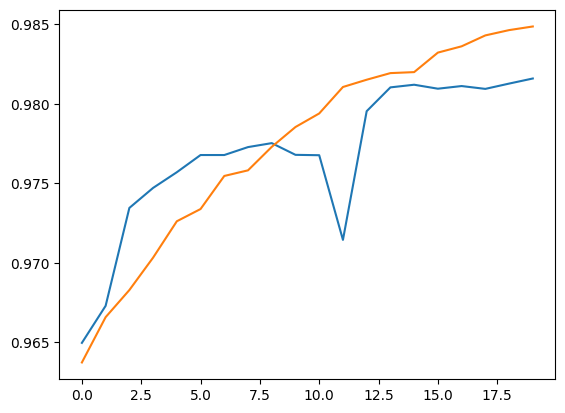

In [22]:
for epoch in range(PARAMS['epochs']):
    # epochループを回す
    model.train()
    train_loss_list = []
    train_accuracy_list = []
    
    for x, y in train_dataloader:
        # 先ほど定義したdataloaderから画像とラベルのセットのdataを取得
        x = x.to(dtype=torch.float32, device=DEVICE)
        y = y.to(dtype=torch.long, device=DEVICE)
        
        # pytorchでは通常誤差逆伝播を行う前に毎回勾配をゼロにする必要がある
        optim.zero_grad()
        # 順伝播を行う
        y_pred = model(x)
        # lossの定義 今回はcross entropyを用います
        loss = criterion(y_pred, y)
        # 誤差逆伝播を行なってモデルを修正します(誤差逆伝播についてはhttp://hokuts.com/2016/05/29/bp1/)
        loss.backward() # 逆伝播の計算
        # 逆伝播の結果からモデルを更新
        optim.step()
        
        train_loss_list.append(loss.item())
        train_accuracy_list.append(accuracy_score_torch(y_pred, y))
    
    model.eval()
    valid_loss_list = []
    valid_accuracy_list = []

    for x, y in valid_dataloader:
        x = x.to(dtype=torch.float32, device=DEVICE)
        y = y.to(dtype=torch.long, device=DEVICE)
        
        with torch.no_grad():
            y_pred = model(x)
            loss = criterion(y_pred, y)
        
        valid_loss_list.append(loss.item())
        valid_accuracy_list.append(accuracy_score_torch(y_pred, y))
    
    print('epoch: {}/{} - loss: {:.5f} - accuracy: {:.3f} - val_loss: {:.5f} - val_accuracy: {:.3f}'.format(
        epoch + 1,
        PARAMS['epochs'] , 
        np.mean(train_loss_list),
        np.mean(train_accuracy_list),
        np.mean(valid_loss_list),
        np.mean(valid_accuracy_list)
    ))
    
    valid_accuracy_history.append(np.mean(valid_accuracy_list))
    traina_accuracy_history.append(np.mean(train_accuracy_list))
plt.plot(valid_accuracy_history[10:])
plt.plot(traina_accuracy_history[10:])
plt.show()
   

In [23]:
PARAMS = {
    'valid_size': 0.2,
    'batch_size': 1024,
    'epochs': 30,
    'lr': 0.03,
    'valid_batch_size': 32,
    'test_batch_size': 32,
}

In [24]:
"""
for me
"""

train_dataset = KMNISTDataset(train_df[ID], train_df[TARGET], PATH['train_image_dir'], transform=transform)
valid_dataset = KMNISTDataset(valid_df[ID], valid_df[TARGET], PATH['train_image_dir'], transform=transform)

# DataLoaderを用いてバッチサイズ分のデータを生成します。shuffleをtrueにすることでデータをshuffleしてくれます
train_dataloader = DataLoader(train_dataset, batch_size=PARAMS['batch_size'], shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=PARAMS['valid_batch_size'], shuffle=False)

optim = SGD(model.parameters(), lr=PARAMS['lr'])
criterion = nn.CrossEntropyLoss()


valid_accuracy_history = []
traina_accuracy_history = []

In [25]:
"""for epoch in range(PARAMS['epochs']):
    # epochループを回す
    model.train()
    train_loss_list = []
    train_accuracy_list = []
    
    for x, y in train_dataloader:
        # 先ほど定義したdataloaderから画像とラベルのセットのdataを取得
        x = x.to(dtype=torch.float32, device=DEVICE)
        y = y.to(dtype=torch.long, device=DEVICE)
        
        # pytorchでは通常誤差逆伝播を行う前に毎回勾配をゼロにする必要がある
        optim.zero_grad()
        # 順伝播を行う
        y_pred = model(x)
        # lossの定義 今回はcross entropyを用います
        loss = criterion(y_pred, y)
        # 誤差逆伝播を行なってモデルを修正します(誤差逆伝播についてはhttp://hokuts.com/2016/05/29/bp1/)
        loss.backward() # 逆伝播の計算
        # 逆伝播の結果からモデルを更新
        optim.step()
        
        train_loss_list.append(loss.item())
        train_accuracy_list.append(accuracy_score_torch(y_pred, y))
    
    model.eval()
    valid_loss_list = []
    valid_accuracy_list = []

    for x, y in valid_dataloader:
        x = x.to(dtype=torch.float32, device=DEVICE)
        y = y.to(dtype=torch.long, device=DEVICE)
        
        with torch.no_grad():
            y_pred = model(x)
            loss = criterion(y_pred, y)
        
        valid_loss_list.append(loss.item())
        valid_accuracy_list.append(accuracy_score_torch(y_pred, y))
    
    print('epoch: {}/{} - loss: {:.5f} - accuracy: {:.3f} - val_loss: {:.5f} - val_accuracy: {:.3f}'.format(
        epoch + 1,
        PARAMS['epochs'] , 
        np.mean(train_loss_list),
        np.mean(train_accuracy_list),
        np.mean(valid_loss_list),
        np.mean(valid_accuracy_list)
    ))
    valid_accuracy_history.append(np.mean(valid_accuracy_list))
    traina_accuracy_history.append(np.mean(train_accuracy_list))
plt.plot(valid_accuracy_history)
plt.plot(traina_accuracy_history)
plt.show()
  
   """

"for epoch in range(PARAMS['epochs']):\n    # epochループを回す\n    model.train()\n    train_loss_list = []\n    train_accuracy_list = []\n    \n    for x, y in train_dataloader:\n        # 先ほど定義したdataloaderから画像とラベルのセットのdataを取得\n        x = x.to(dtype=torch.float32, device=DEVICE)\n        y = y.to(dtype=torch.long, device=DEVICE)\n        \n        # pytorchでは通常誤差逆伝播を行う前に毎回勾配をゼロにする必要がある\n        optim.zero_grad()\n        # 順伝播を行う\n        y_pred = model(x)\n        # lossの定義 今回はcross entropyを用います\n        loss = criterion(y_pred, y)\n        # 誤差逆伝播を行なってモデルを修正します(誤差逆伝播についてはhttp://hokuts.com/2016/05/29/bp1/)\n        loss.backward() # 逆伝播の計算\n        # 逆伝播の結果からモデルを更新\n        optim.step()\n        \n        train_loss_list.append(loss.item())\n        train_accuracy_list.append(accuracy_score_torch(y_pred, y))\n    \n    model.eval()\n    valid_loss_list = []\n    valid_accuracy_list = []\n\n    for x, y in valid_dataloader:\n        x = x.to(dtype=torch.float32, device=DEVICE)\n        y 

In [26]:
"""PARAMS = {
    'valid_size': 0.2,
    'batch_size': 256,
    'epochs': 30,
    'lr': 0.001,
    'valid_batch_size': 2**13,
    'test_batch_size': 2**13,
}"""

"PARAMS = {\n    'valid_size': 0.2,\n    'batch_size': 256,\n    'epochs': 30,\n    'lr': 0.001,\n    'valid_batch_size': 2**13,\n    'test_batch_size': 2**13,\n}"

In [27]:
"""for epoch in range(PARAMS['epochs']):
    # epochループを回す
    model.train()
    train_loss_list = []
    train_accuracy_list = []
    
    for x, y in train_dataloader:
        # 先ほど定義したdataloaderから画像とラベルのセットのdataを取得
        x = x.to(dtype=torch.float32, device=DEVICE)
        y = y.to(dtype=torch.long, device=DEVICE)
        
        # pytorchでは通常誤差逆伝播を行う前に毎回勾配をゼロにする必要がある
        optim.zero_grad()
        # 順伝播を行う
        y_pred = model(x)
        # lossの定義 今回はcross entropyを用います
        loss = criterion(y_pred, y)
        # 誤差逆伝播を行なってモデルを修正します(誤差逆伝播についてはhttp://hokuts.com/2016/05/29/bp1/)
        loss.backward() # 逆伝播の計算
        # 逆伝播の結果からモデルを更新
        optim.step()
        
        train_loss_list.append(loss.item())
        train_accuracy_list.append(accuracy_score_torch(y_pred, y))
    
    model.eval()
    valid_loss_list = []
    valid_accuracy_list = []

    for x, y in valid_dataloader:
        x = x.to(dtype=torch.float32, device=DEVICE)
        y = y.to(dtype=torch.long, device=DEVICE)
        
        with torch.no_grad():
            y_pred = model(x)
            loss = criterion(y_pred, y)
        
        valid_loss_list.append(loss.item())
        valid_accuracy_list.append(accuracy_score_torch(y_pred, y))
    
    print('epoch: {}/{} - loss: {:.5f} - accuracy: {:.3f} - val_loss: {:.5f} - val_accuracy: {:.3f}'.format(
        epoch + 1,
        PARAMS['epochs'] , 
        np.mean(train_loss_list),
        np.mean(train_accuracy_list),
        np.mean(valid_loss_list),
        np.mean(valid_accuracy_list)
    ))
  
   """

"for epoch in range(PARAMS['epochs']):\n    # epochループを回す\n    model.train()\n    train_loss_list = []\n    train_accuracy_list = []\n    \n    for x, y in train_dataloader:\n        # 先ほど定義したdataloaderから画像とラベルのセットのdataを取得\n        x = x.to(dtype=torch.float32, device=DEVICE)\n        y = y.to(dtype=torch.long, device=DEVICE)\n        \n        # pytorchでは通常誤差逆伝播を行う前に毎回勾配をゼロにする必要がある\n        optim.zero_grad()\n        # 順伝播を行う\n        y_pred = model(x)\n        # lossの定義 今回はcross entropyを用います\n        loss = criterion(y_pred, y)\n        # 誤差逆伝播を行なってモデルを修正します(誤差逆伝播についてはhttp://hokuts.com/2016/05/29/bp1/)\n        loss.backward() # 逆伝播の計算\n        # 逆伝播の結果からモデルを更新\n        optim.step()\n        \n        train_loss_list.append(loss.item())\n        train_accuracy_list.append(accuracy_score_torch(y_pred, y))\n    \n    model.eval()\n    valid_loss_list = []\n    valid_accuracy_list = []\n\n    for x, y in valid_dataloader:\n        x = x.to(dtype=torch.float32, device=DEVICE)\n        y 

In [28]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

test_dataset = KMNISTDataset(
    sample_submission_df[ID],
    sample_submission_df[TARGET],
    PATH['test_image_dir'],
    transform=transform
)

test_dataloader = DataLoader(test_dataset, batch_size=PARAMS['test_batch_size'], shuffle=False)

In [29]:
model.eval()
predictions = []

for x, _ in test_dataloader:
    x = x.to(dtype=torch.float32, device=DEVICE)
    
    with torch.no_grad():
        y_pred = model(x)
        y_pred = torch.argmax(y_pred, axis=1).cpu().numpy()
        y_pred = y_pred.tolist()
        
    predictions += y_pred

In [30]:
sample_submission_df[TARGET] = predictions

In [31]:
sample_submission_df.to_csv('submission.csv', index=False)
from IPython.display import FileLink
FileLink('submission.csv')

/home/n2b/BootCamp23/kaggle/bootcamp-kaggle/notebook/submission.csv

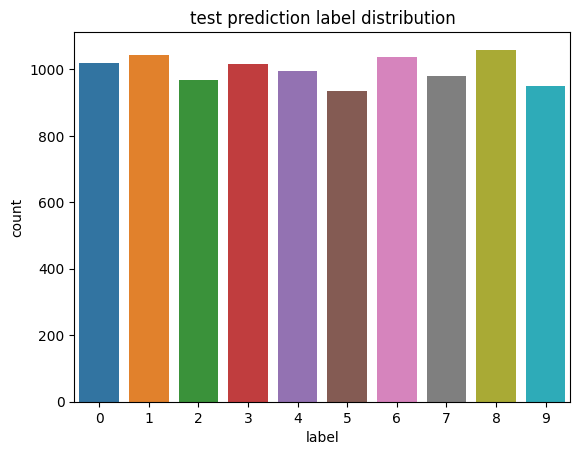

In [32]:
sns.countplot(x = sample_submission_df[TARGET])
plt.title('test prediction label distribution')
plt.show()

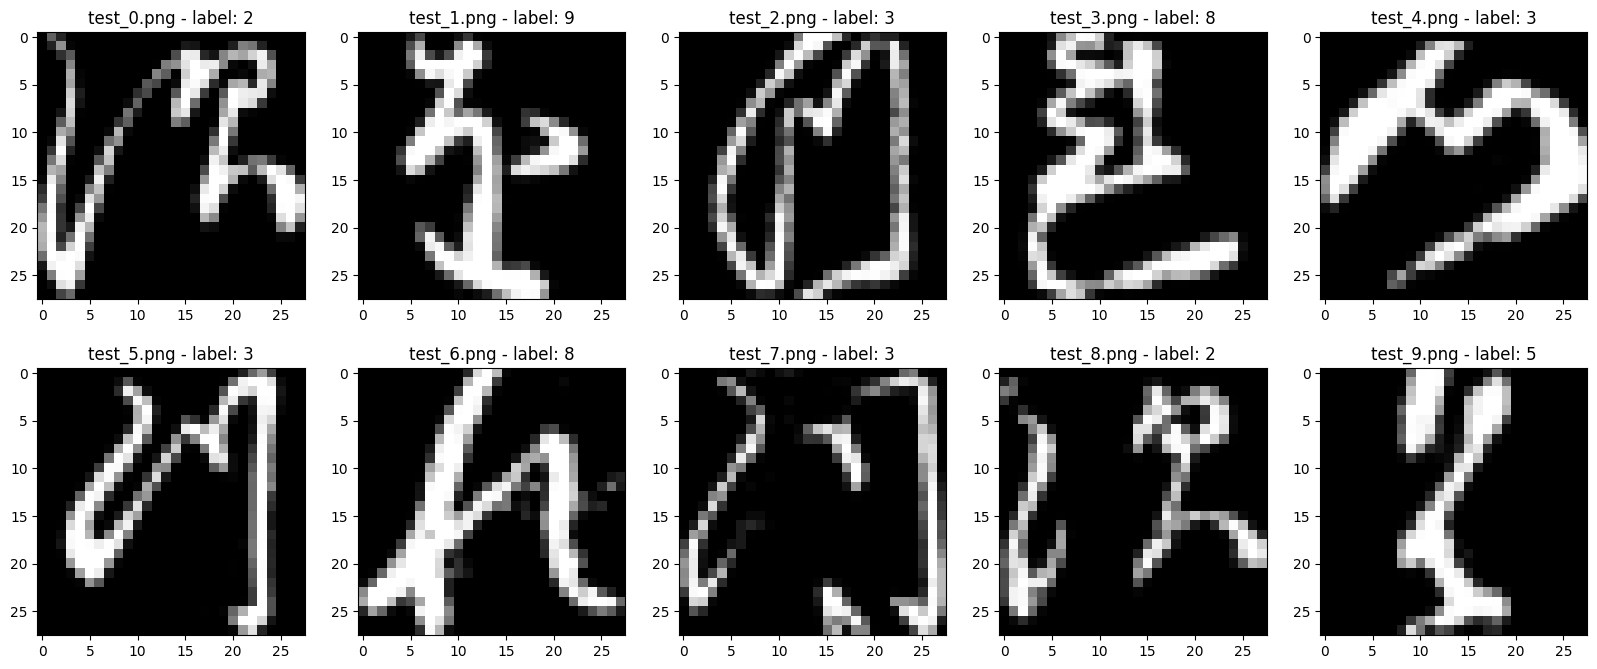

In [33]:
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(4 * 5, 4 * 2)

for i, row in sample_submission_df.iloc[:10,:].iterrows():
    fname, label = row[ID], row[TARGET]
    img = cv2.imread(os.path.join(PATH['test_image_dir'], fname))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ax[i//5,i%5].imshow(img, 'gray')
    ax[i//5,i%5].set_title(f'{fname} - label: {label}')